In [ ]:
import torch
from torch import nn
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [ ]:
def indexToLabel(idx):
  map = {
      0 : 'AnnualCrop',
      1 : 'Forest',
      2 : 'HerbaceousVegatation',
      3 : 'Highway',
      4 : 'Industrial',
      5 : 'Pasture',
      6 : 'PermanentCrop',
      7 : 'Residential',
      8 : 'River',
      9 : 'SeaLake'
  }
  for key in map:
    if key == idx:
      return map[key]

In [ ]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        torch.nn.init.kaiming_uniform_(m.weight)

class idBlock(nn.Module):
  def __init__(self,inChannel,filters,kernelSize):
    super().__init__()
    self.inChannel = inChannel
    self.kernelSize = kernelSize
    self.f1, self.f2, self.f3 = filters
    self.relu = nn.ReLU()
    self.conv1 = nn.Sequential(
        nn.Conv2d(self.inChannel, self.f1, 1),
        nn.BatchNorm2d(self.f1),
        nn.ReLU())
    self.conv2 = nn.Sequential(
        nn.Conv2d(self.f1,self.f2,self.kernelSize,padding = 'same'),
        nn.BatchNorm2d(self.f2),
        nn.ReLU())
    self.conv3 = nn.Sequential(
        nn.Conv2d(self.f2,self.f3,1),
        nn.BatchNorm2d(self.f3))
  def forward(self,x):
    xShortcut = x
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = torch.add(x,xShortcut)
    x = self.relu(x)
    return x

class convBlock(nn.Module):
  def __init__(self,inChannel,filters,kernelSize,stride = 2):
    super().__init__()
    self.inChannel = inChannel
    self.kernelSize = kernelSize
    self.stride = stride
    self.relu = nn.ReLU()
    self.f1, self.f2, self.f3 = filters
    self.conv1 = nn.Sequential(
        nn.Conv2d(self.inChannel, self.f1, 1, self.stride),
        nn.BatchNorm2d(self.f1),
        nn.ReLU())
    self.conv2 = nn.Sequential(
        nn.Conv2d(self.f1,self.f2,self.kernelSize,padding = 'same'),
        nn.BatchNorm2d(self.f2),
        nn.ReLU())
    self.conv3 = nn.Sequential(
        nn.Conv2d(self.f2,self.f3,1),
        nn.BatchNorm2d(self.f3))
    self.convShort = nn.Sequential(
        nn.Conv2d(self.inChannel,self.f3,1,self.stride),
        nn.BatchNorm2d(self.f3))

  def forward(self,x):
    xShortcut = self.convShort(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = torch.add(x,xShortcut)
    x = self.relu(x)
    return x

class resNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.ZeroPad2d(3),
            nn.Conv2d(3,64,7,2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )
        self.network.apply(init_weights)
        self.layer1 = nn.Sequential(
            convBlock(64,[64, 64, 256],3, stride=1),
            idBlock(256, [64, 64, 256],3),
            idBlock(256, [64, 64, 256],3)
        )
        self.layer1.apply(init_weights)
        self.layer2 = nn.Sequential(
            convBlock(256,[128,128,512],3),
            idBlock(512, [128, 128, 512],3),
            idBlock(512, [128, 128, 512],3),
            idBlock(512, [128, 128, 512],3)
        )
        self.layer2.apply(init_weights)
        self.layer3 = nn.Sequential(
            convBlock(512,[256,256,1024],3),
            idBlock(1024, [256,256,1024],3),
            idBlock(1024, [256,256,1024],3),
            idBlock(1024, [256,256,1024],3),
            idBlock(1024, [256,256,1024],3),
            idBlock(1024, [256,256,1024],3)
        )
        self.layer3.apply(init_weights)
        self.layer4 = nn.Sequential(
            convBlock(1024,[512, 512, 2048],3),
            idBlock(2048, [512, 512, 2048],3),
            idBlock(2048, [512, 512, 2048],3)
        )
        self.layer4.apply(init_weights)
        self.avgPool = nn.AvgPool2d(2)
        self.flatten = nn.Flatten()
        self.flatten.apply(init_weights)
        self.linear = nn.Linear(2048,10)
        self.linear.apply(init_weights)

    def forward(self,x):
      x = self.network(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgPool(x)
      x = self.flatten(x)
      x = self.linear(x)
      return x

In [ ]:
model = resNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Eurosat Classification/weights.pth'))

<All keys matched successfully>

In [ ]:
def inference(imgPath, model):
  img = read_image(imgPath)
  img = img.type(torch.float)
  img = torch.unsqueeze(img,0)
  model.eval()
  with torch.no_grad():
    pred = model(img)
    out = indexToLabel(pred.argmax(1))
  return out

Forest


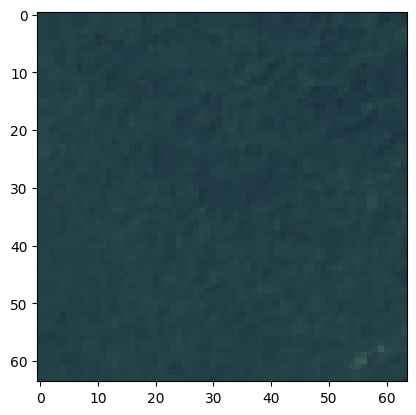

In [ ]:
imagePath = '/content/drive/MyDrive/Datasets/Eurosat/2750/Forest/Forest_7.jpg'
print(inference(imagePath,model))
plt.imshow(read_image(imagePath).permute(1,2,0))